# Heading Correlation Analysis
## Comparing True vs Reconstructed Heading Over Time

This notebook analyzes how well the reconstructed heading from grid cell activity correlates with the true heading of the animal over time.

## 1. Setup and Imports

In [9]:
%load_ext autoreload
%autoreload 2

%run ../setup_project.py
%run ../generic_plot_functions.py
%run Fig5/functions.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, signal
from scipy.ndimage import gaussian_filter1d
import pickle
import os

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Load Data

In [10]:
# Setup project
projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(
    projectName="autopi_mec",
    dataPath=PROJECT_DATA_PATH,
    dlcModelPath=""
)

# Load cells information
fn = myProject.dataPath + "/results/cells.csv"
print("Loading", fn)
cells = pd.read_csv(fn)

# Load open field reconstruction data
fn = myProject.dataPath + "/results/reconstuctionDFOF.csv"
print("Loading", fn)
dfOF = pd.read_csv(fn)

# Load AutoPI reconstruction data
fn = myProject.dataPath + "/results/reconstuctionDFAutoPI.csv"
print("Loading", fn)
dfAutoPI = pd.read_csv(fn)

print(f"\nOpen Field data: {len(dfOF)} time points, {dfOF.session.nunique()} sessions")
print(f"AutoPI data: {len(dfAutoPI)} time points, {dfAutoPI.session.nunique()} sessions")

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: E:\GitHub\Peng_et.al_2025_noInt\Peng
dlcModelPath: 
Reading E:\GitHub\Peng_et.al_2025_noInt\Peng/sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions
Loading E:\GitHub\Peng_et.al_2025_noInt\Peng/results/cells.csv
Loading E:\GitHub\Peng_et.al_2025_noInt\Peng/results/reconstuctionDFOF.csv
Loading E:\GitHub\Peng_et.al_2025_noInt\Peng/results/reconstuctionDFAutoPI.csv

Open Field data: 4159092 time points, 49 sessions
AutoPI data: 6617357 time points, 49 sessions


## 3. Single Trial Analysis: Heading Error Over Time

In [11]:
# Select an example session and trial
example_session = 'jp3269-28112022-0108'
example_trial = 4  # You can change this

# Filter data for this session/trial
if example_trial is not None:
    trial_data = dfAutoPI[(dfAutoPI.session == example_session) & 
                          (dfAutoPI.trial == example_trial)].copy()
    title_suffix = f" - Trial {example_trial}"
else:
    trial_data = dfOF[dfOF.session == example_session].copy()
    title_suffix = " - Open Field"

# Calculate time relative to start
trial_data['time_rel'] = trial_data['recTime'] - trial_data['recTime'].iloc[0]

print(f"Session: {example_session}")
print(f"Duration: {trial_data['time_rel'].iloc[-1]:.2f} seconds")
print(f"Data points: {len(trial_data)}")
print(f"Mean speed: {trial_data['speed'].mean():.2f} cm/s")

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
Session: jp3269-28112022-0108
Duration: 664.38 seconds
Data points: 2588
Mean speed: 22.52 cm/s


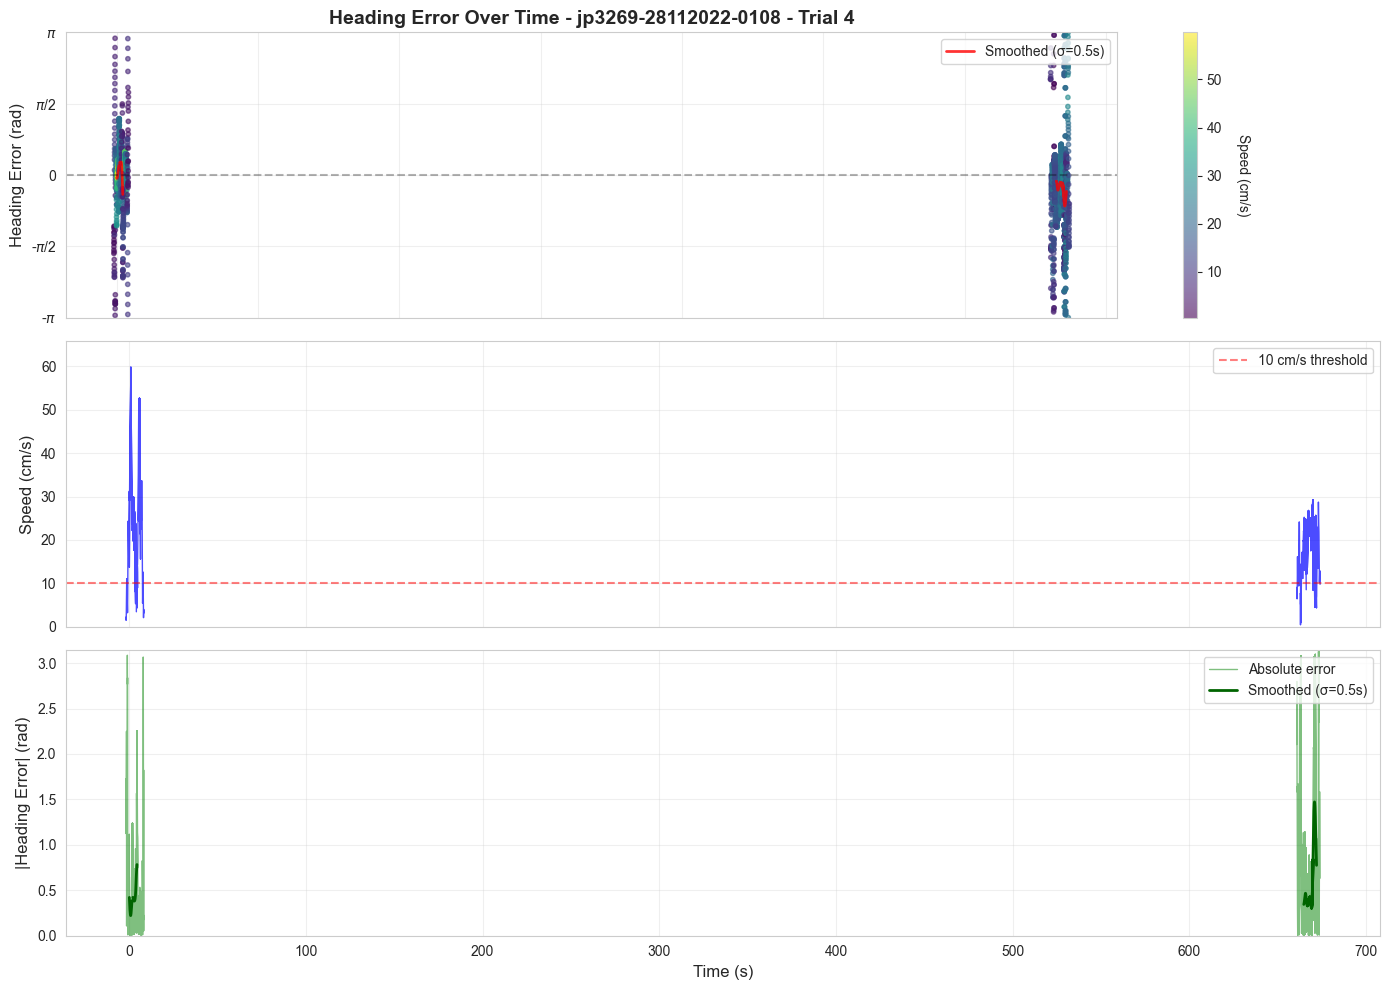


Summary Statistics:
Mean heading error: -0.162 rad
Median heading error: nan rad
Mean absolute error: 0.607 rad
Std of error: 0.880 rad


In [12]:
# Plot heading error over time with speed information
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Panel 1: Heading error over time
ax = axes[0]
scatter = ax.scatter(trial_data['time_rel'], 
                    trial_data['mvtDirError'],
                    c=trial_data['speed'],
                    s=10, alpha=0.6, cmap='viridis')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Speed (cm/s)', rotation=270, labelpad=20)

# Add smoothed line
window = 25  # 0.5 second window at 50 Hz
smoothed_error = gaussian_filter1d(trial_data['mvtDirError'], sigma=window)
ax.plot(trial_data['time_rel'], smoothed_error, 'r-', linewidth=2, 
        label=f'Smoothed (σ={window/50:.1f}s)', alpha=0.8)

ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax.set_ylabel('Heading Error (rad)', fontsize=12)
ax.set_ylim(-np.pi, np.pi)
ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_yticklabels([r'-$\pi$', r'-$\pi$/2', '0', r'$\pi$/2', r'$\pi$'])
ax.legend(loc='upper right')
ax.set_title(f'Heading Error Over Time - {example_session}{title_suffix}', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Panel 2: Speed over time
ax = axes[1]
ax.plot(trial_data['time_rel'], trial_data['speed'], 'b-', linewidth=1, alpha=0.7)
ax.axhline(y=10, color='r', linestyle='--', alpha=0.5, label='10 cm/s threshold')
ax.set_ylabel('Speed (cm/s)', fontsize=12)
ax.legend(loc='upper right')
ax.set_ylim(0, trial_data['speed'].max() * 1.1)
ax.grid(True, alpha=0.3)

# Panel 3: Absolute heading error over time
ax = axes[2]
abs_error = np.abs(trial_data['mvtDirError'])
ax.plot(trial_data['time_rel'], abs_error, 'g-', linewidth=1, alpha=0.5, label='Absolute error')
smoothed_abs_error = gaussian_filter1d(abs_error, sigma=window)
ax.plot(trial_data['time_rel'], smoothed_abs_error, 'darkgreen', linewidth=2, 
        label=f'Smoothed (σ={window/50:.1f}s)')
ax.set_ylabel('|Heading Error| (rad)', fontsize=12)
ax.set_xlabel('Time (s)', fontsize=12)
ax.legend(loc='upper right')
ax.set_ylim(0, np.pi)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Mean heading error: {np.mean(trial_data['mvtDirError']):.3f} rad")
print(f"Median heading error: {np.median(trial_data['mvtDirError']):.3f} rad")
print(f"Mean absolute error: {np.mean(abs_error):.3f} rad")
print(f"Std of error: {np.std(trial_data['mvtDirError']):.3f} rad")

## 4. Circular Statistics: Mean Vector Length Over Time

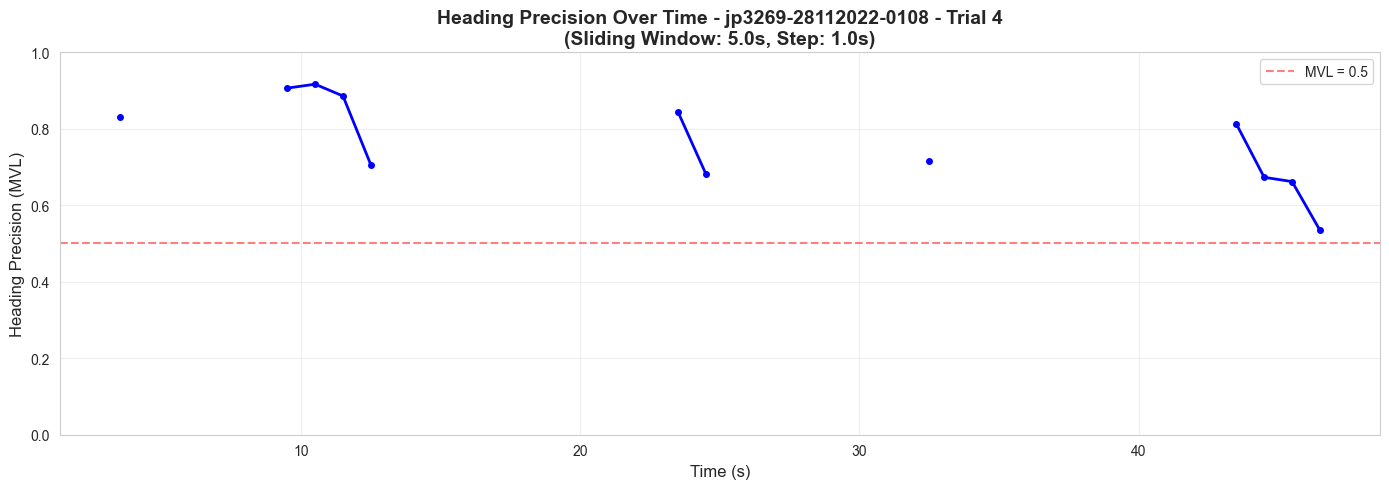


MVL Analysis (window=5.0s):
Mean MVL: nan
Min MVL: nan
Max MVL: nan
Std MVL: nan


In [13]:
# Calculate MVL (Mean Vector Length) in sliding windows
def calculate_mvl_sliding_window(errors, window_size=250, step=50):
    """
    Calculate MVL in sliding windows.
    window_size and step are in number of samples (50 Hz sampling rate)
    """
    mvls = []
    times = []
    
    for i in range(0, len(errors) - window_size, step):
        window_data = errors[i:i+window_size]
        mvl = vl_mvt_direction_error(window_data)
        mvls.append(mvl)
        times.append(i + window_size/2)  # Center of window
    
    return np.array(times), np.array(mvls)

# Calculate for the example trial
window_size = 250  # 5 seconds at 50 Hz
step = 50  # 1 second step

times_mvl, mvls = calculate_mvl_sliding_window(
    trial_data['mvtDirError'].values, 
    window_size=window_size, 
    step=step
)

# Convert to seconds
times_mvl_sec = times_mvl / 50

# Plot
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(times_mvl_sec, mvls, 'b-', linewidth=2, marker='o', markersize=4)
ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='MVL = 0.5')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Heading Precision (MVL)', fontsize=12)
ax.set_title(f'Heading Precision Over Time - {example_session}{title_suffix}\n' + 
             f'(Sliding Window: {window_size/50:.1f}s, Step: {step/50:.1f}s)', 
             fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nMVL Analysis (window={window_size/50:.1f}s):")
print(f"Mean MVL: {np.mean(mvls):.3f}")
print(f"Min MVL: {np.min(mvls):.3f}")
print(f"Max MVL: {np.max(mvls):.3f}")
print(f"Std MVL: {np.std(mvls):.3f}")

## 5. Summary

This notebook demonstrates how to correlate true heading with reconstructed heading over time:

**Key Metrics:**
- `mvtDirError`: Instantaneous heading error at each time point (radians)
- `MVL (Mean Vector Length)`: Circular measure of heading precision (0-1, where 1 = perfect)
- Speed-dependent accuracy analysis

**Key Functions Used:**
- `mvt_direction_error()`: Calculate heading error
- `vl_mvt_direction_error()`: Calculate MVL
- `mean_mvt_direction_error()`: Calculate mean circular error

**Adjustable Parameters:**
- `example_session`: Session name to analyze
- `example_trial`: Trial number (or None for open field)
- `window_size`: Sliding window size for MVL calculation (samples at 50 Hz)
- `step`: Step size for sliding window